In [19]:
# Enable autoreload for development
import IPython
ipython = IPython.get_ipython()
ipython.run_line_magic('load_ext', 'autoreload')
ipython.run_line_magic('autoreload', '2')

# Auxiliar imports
import sys, os, time
import matplotlib.pyplot as plt
import numpy as np

# Gym imports
import gym
from gym.vector import SyncVectorEnv

# PyTorch imports
import torch
from torch import nn, optim


# Custom imports
sys.path.append(os.path.abspath('..')) # Add parent directory to path

from ppo_network import PPONetworkDiscrete
from ppo import PPODiscrete
from hp_tuner import HPTuner

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# CartPole environment
env_id = 'CartPole-v1'
max_episode_steps = 1024
num_envs = 16

# Environment kwargs
env_kwargs = {
    'id': env_id,
    'max_episode_steps': max_episode_steps,
}

# Create vectorized environment
envs_vector = SyncVectorEnv([lambda: gym.make(**env_kwargs)] * num_envs)
states, infos = envs_vector.reset()

In [21]:
# Policy-Value Network
network_kwargs = {
    'input_dims': 4,
    'output_dims': 2,
    'shared_hidden_dims': [512, 256, 128],
    'shared_activation': nn.ReLU,
    'policy_hidden_dims': [64, 64],
    'policy_activation': nn.ReLU,
    'value_hidden_dims': [64, 64],
    'value_activation': nn.ReLU,
}

# Create policy-value network
network = PPONetworkDiscrete(**network_kwargs)

In [22]:
# Test forward pass
for _ in range(3):
    states_tensor = torch.tensor(states, dtype=torch.float32)
    policy, value = network(states_tensor)
    
    actions_dist = torch.distributions.Categorical(logits=policy)
    actions = actions_dist.sample().numpy()
    
    states, rewards, dones, truncateds, infos = envs_vector.step(actions)
    print(f"State: {states[0]}"[:80])

State: [-0.02979096 -0.15914853 -0.03523685  0.24774519]
State: [-0.03297393 -0.35375    -0.03028195  0.5291087 ]
State: [-0.04004893 -0.1582154  -0.01969977  0.22703974]


In [23]:
# PPO hyperparameters
ppo_kwargs = {
    'network_class': PPONetworkDiscrete,
    'network_kwargs': network_kwargs,
    'num_envs': num_envs,
    'lr': 3e-4,
    'final_lr': 1e-6,
    'gamma': 0.99,
    'lam': 0.99,
    'clip_eps': 0.25,
    'final_clip_eps': 0.01,
    'value_coef': 0.7,
    'entropy_coef': 0.2,
    'final_entropy_coef': 0.01,
    'batch_size': 1024,
    'mini_batch_size': 128,
    'batch_epochs': 8,
    'batch_shuffle': True,
    'reward_normalization': True,
    'truncated_reward': 5,
}

ppo = PPODiscrete(envs_vector, **ppo_kwargs)

# Test PPO training
ppo.train(1)

array([120.44])

Optimizing lr with values: [0.001, 0.0003, 0.0001]
Skipping lr = 0.001, score: 23301.20
Skipping lr = 0.0003, score: 23386.07
Skipping lr = 0.0001, score: 20717.25
Best value for lr: 0.0003
No change in lr, no change ratio: 0.1


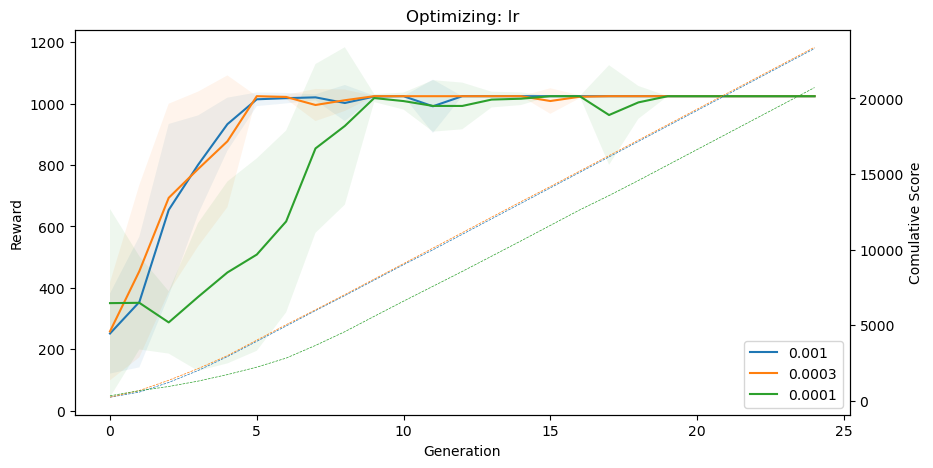

Optimizing lam with values: [0.95, 0.99]
Skipping lam = 0.95, score: 21377.43
Skipping lam = 0.99, score: 23386.07
Best value for lam: 0.99
No change in lam, no change ratio: 0.2


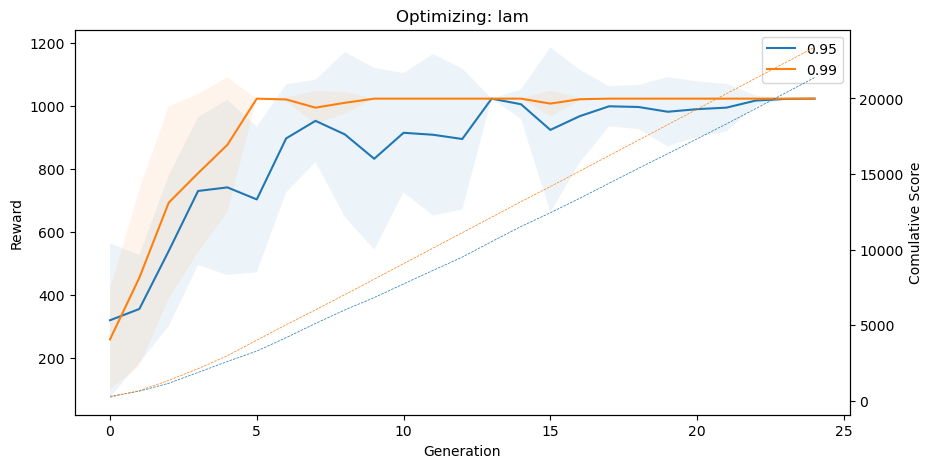

Optimizing gamma with values: [0.98, 0.99, 0.995, 0.999]
Skipping gamma = 0.98, score: 22749.80
Skipping gamma = 0.99, score: 23386.07
Skipping gamma = 0.995, score: 22847.35
Skipping gamma = 0.999, score: 22062.70
Best value for gamma: 0.99
No change in gamma, no change ratio: 0.3


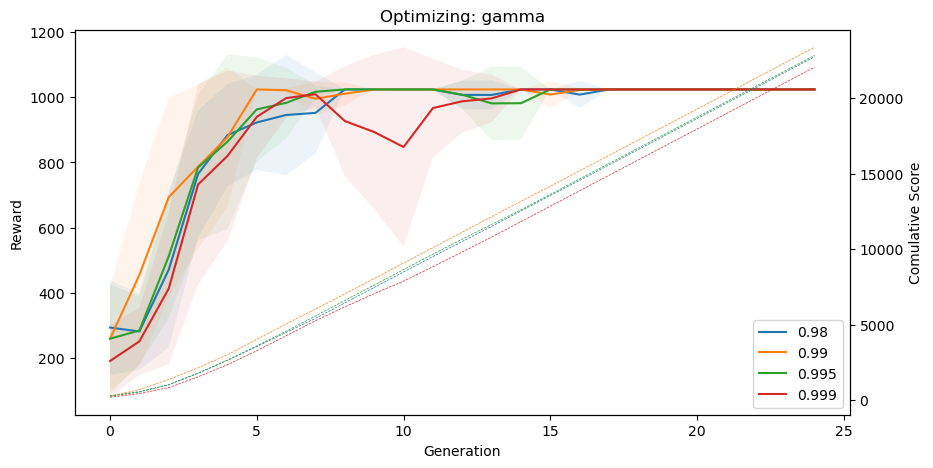

Optimizing value_coef with values: [0.495, 0.7, 0.9899]
Skipping value_coef = 0.495, score: 21718.34
Skipping value_coef = 0.7, score: 23386.07
Skipping value_coef = 0.9899, score: 22747.44
Best value for value_coef: 0.7
No change in value_coef, no change ratio: 0.4


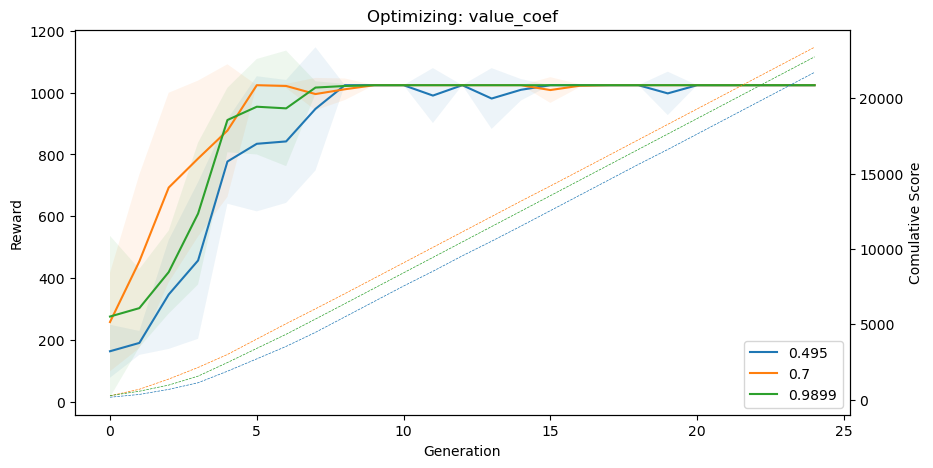

Optimizing entropy_coef with values: [0.1414, 0.2, 0.2828]
Skipping entropy_coef = 0.1414, score: 22682.73
Skipping entropy_coef = 0.2, score: 23386.07
Skipping entropy_coef = 0.2828, score: 22007.82
Best value for entropy_coef: 0.2
No change in entropy_coef, no change ratio: 0.5


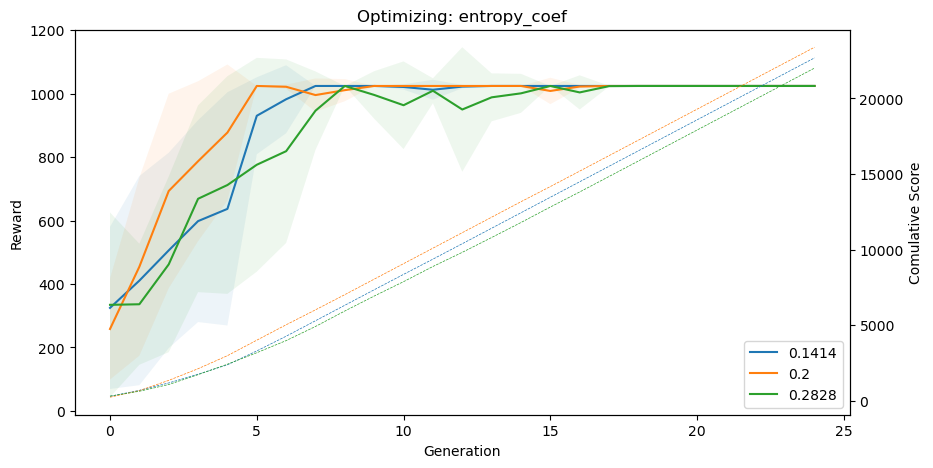

Optimizing clip_eps with values: [0.1768, 0.25, 0.3536]
Skipping clip_eps = 0.1768, score: 21310.45
Skipping clip_eps = 0.25, score: 23386.07
Skipping clip_eps = 0.3536, score: 22796.63
Best value for clip_eps: 0.25
No change in clip_eps, no change ratio: 0.6


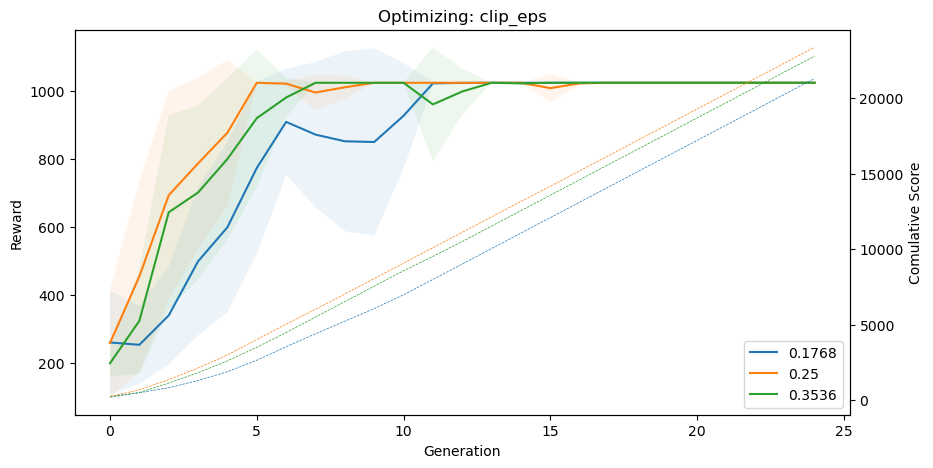

Optimizing mini_batch_size with values: [91, 128, 181]
Skipping mini_batch_size = 91, score: 22918.07
Skipping mini_batch_size = 128, score: 23386.07
Skipping mini_batch_size = 181, score: 21728.07
Best value for mini_batch_size: 128
No change in mini_batch_size, no change ratio: 0.7


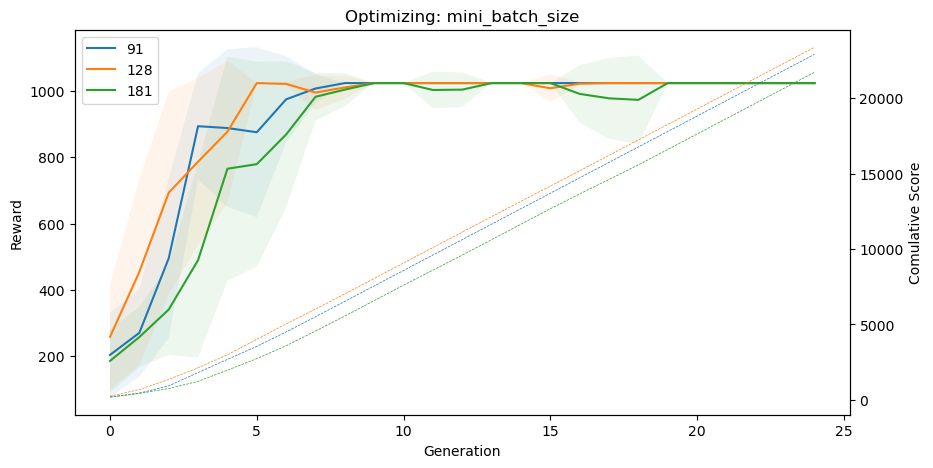

Optimizing batch_epochs with values: [6, 8, 11]
Skipping batch_epochs = 6, score: 22522.95
Skipping batch_epochs = 8, score: 23386.07
Skipping batch_epochs = 11, score: 22768.76
Best value for batch_epochs: 8
No change in batch_epochs, no change ratio: 0.8


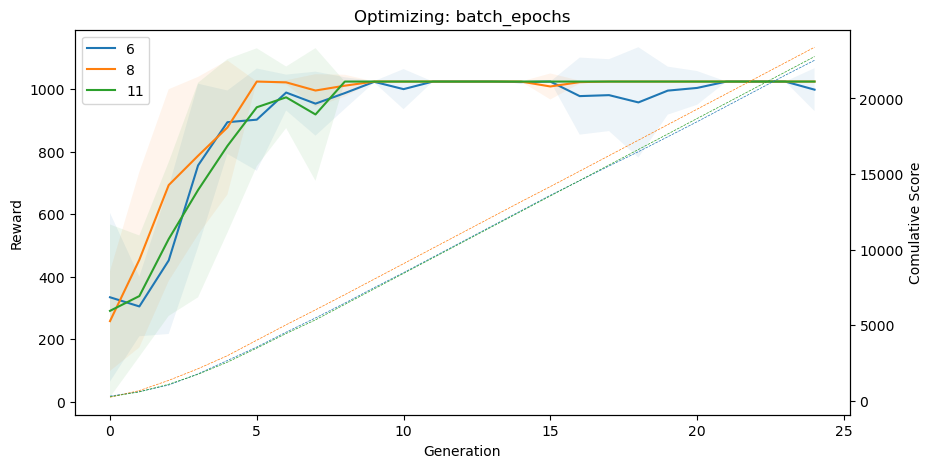

Optimizing batch_shuffle with values: [True, False]
Skipping batch_shuffle = True, score: 23386.07
Skipping batch_shuffle = False, score: 21855.73
Best value for batch_shuffle: True
No change in batch_shuffle, no change ratio: 0.9


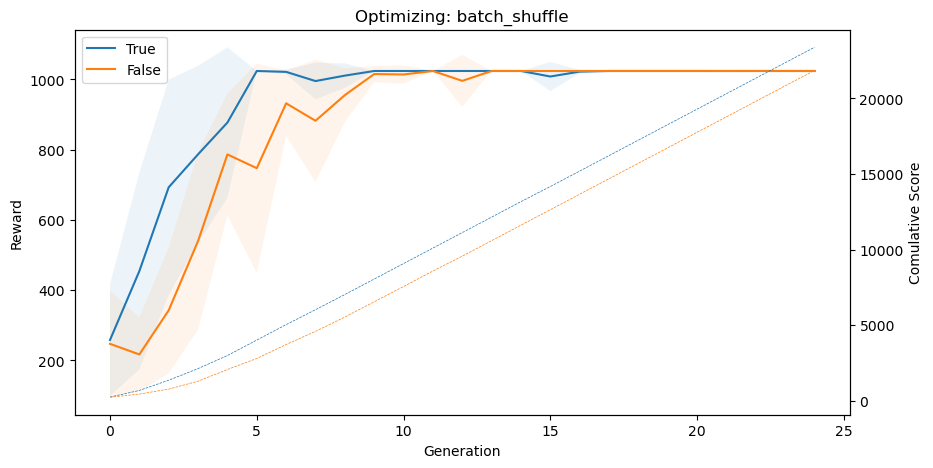

Optimizing reward_normalization with values: [True, False]
Skipping reward_normalization = True, score: 23386.07
Skipping reward_normalization = False, score: 22603.20
Best value for reward_normalization: True
No change in reward_normalization, no change ratio: 1.0


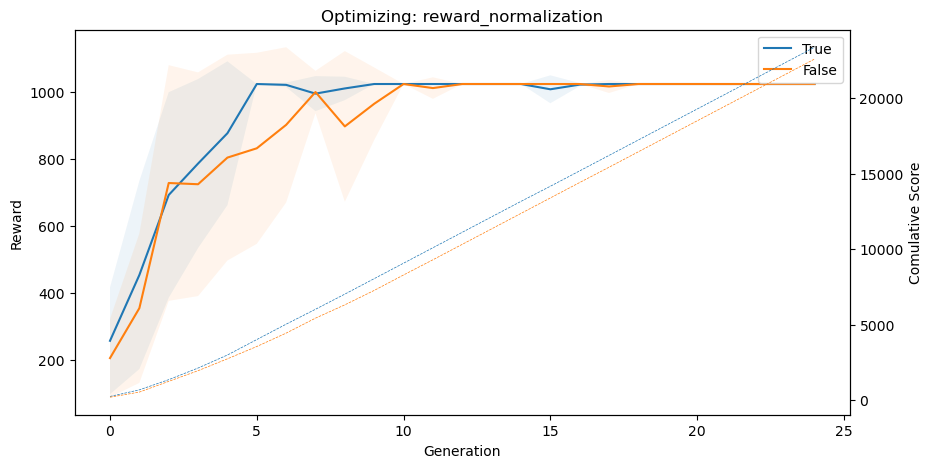

Running evolution with save generations: [0, 20, 40, 60, 80, 100]
Video saved to videos/evo_video_100_gens_52d1635e.mp4


In [24]:
# Hyperparameter tuning
hp_tuner = HPTuner(
    env_kwargs=env_kwargs,
    num_envs=num_envs,
    ppo_class=PPODiscrete,
    ppo_kwargs=ppo_kwargs,
)

# Define hyperparameters to optimize
parameters = [
    ('lr', [1e-3, 3e-4, 1e-4]),
    ('lam', [0.95, 0.99, 0.995]),
    ('gamma', [0.98, 0.99, 0.995, 0.999]),
    'value_coef',
    'entropy_coef',
    'clip_eps',
    'mini_batch_size',
    'batch_epochs',
    'batch_shuffle',
    'reward_normalization',
    ]

# Optimize hyperparameters
evolutions = hp_tuner.optimize_hyperparameters(
    parameters, generations=25, num_trials = 8,
    )

# Create video
hp_tuner.evolution_video(
    generations=100, video_folder = 'videos', increments=5, max_frames=max_episode_steps,
    )

In [27]:
for parameter in hp_tuner.ppo_kwargs:
    print(f"{parameter}: {hp_tuner.ppo_kwargs[parameter]}")

network_class: <class 'ppo_network.PPONetworkDiscrete'>
network_kwargs: {'input_dims': 4, 'output_dims': 2, 'shared_hidden_dims': [512, 256, 128], 'shared_activation': <class 'torch.nn.modules.activation.ReLU'>, 'policy_hidden_dims': [64, 64], 'policy_activation': <class 'torch.nn.modules.activation.ReLU'>, 'value_hidden_dims': [64, 64], 'value_activation': <class 'torch.nn.modules.activation.ReLU'>}
num_envs: 16
lr: 0.0003
final_lr: 1e-06
gamma: 0.99
lam: 0.99
clip_eps: 0.25
final_clip_eps: 0.01
value_coef: 0.7
entropy_coef: 0.2
final_entropy_coef: 0.01
batch_size: 1024
mini_batch_size: 128
batch_epochs: 8
batch_shuffle: True
reward_normalization: True
truncated_reward: 5
